# Acoustic Absorption calculation using the Transfer Matrix Method (TMM) with Biot-JCAL Models

This notebook explains how to use the **Transfer Matrix Method (TMM)** together with the **Biot** and **Johnson-Champoux-Allard-Lafarge (JCAL)** models 
to calculate the **acoustic absorption** of a porous material covered with and without a thin plate (foil) backed by a rigid wall.
The thin plate is considered as a mass term. It's a 1D model.

---

## 1. Import Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

---

## 2. Define JCAL Model Functions

These functions define the **effective dynamic density** and **effective bulk modulus** of the porous medium according to the **JCAL model**. It uses $e^{-i\omega t}$ convention. The equations have been obtained from [https://doi.org/10.1121/1.415222]


In [2]:
# Dymanic density
def rho_eff(omega, rho0, phi, alpha_inf, sigma, eta, Lambda):
    term = 1 - (4j*alpha_inf**2 * eta * rho0 * omega) / (sigma*Lambda*phi)**2
    
    return alpha_inf * (rho0 - sigma*phi/(1j*omega*alpha_inf) * np.sqrt(term))

# Dynamic Bulk modulus 

def K_eff(gamma, P0, phi, eta, Cp, rho0, omega, kappa, Lambda_prime, NPr):
    term = 1 - 8*eta/(1j*Lambda_prime**2*NPr*omega*rho0) * np.sqrt(1 - 1j*rho0*omega*NPr*Lambda_prime/16/eta)
    return  gamma * P0 / (gamma - (gamma - 1) / term)

## 3. Material properties

The air properties, JCAL parameters, Biot parameters and surface mass density of the foil are


In [3]:
# Air properties
rho1  = 1.2             # Density [Kg/m**3]
gamma = 1.4             # Heat capacity ratio []
Cp    = 1006            # Specific heat capacity [J/(kg*K)] 
P0    = 101325          # Pressure [Pa]
mu    = 1.8e-5          # Dynamic viscosity [Pa*s]
kappa = 25e-3           # Coefficient of thermal conduction [W/(m*K)] 
NPr   = Cp * mu / kappa # Prandtl number

# Porous material properties
a            = 20e-3  # Thickness [m] 
sigma        = 50000  # Airflow resistivity  [Pa*s/m2] [N*s/m4]
phi          = 0.95   # Porosity []
alpha_inf    = 1.0    # Tortuosity []
Lambda       = 60e-6  # Viscous characteristic length [m]
Lambda_prime = 100e-6 # Thermal characteristic length [m]
# Note that k0_prime, the Static thermal permeability [m2] is not used in this model

# Biot model properties
young = 200e3 # [Pa]
poisson = 0.2 # Poisson coefficient
rho3  = 100 # [Kg/m^3]
eta   = 0.1 # [%] Loss factor

# Foil properties
rhoP = 2800  * 20e-6 # Surface density [Kg/m**2]

# List of frequencies to be computed
N       = 200  # Number of points
MaxFreq = 6000 # Max frequency
MinFreq = 100  # Min frequency

FreqList = np.linspace(MinFreq,MaxFreq,N)
omegaList = FreqList * 2*np.pi

###   Remove the # symbol in the following two lines to compute the values in the One-third octave band center frequencies. ####

#omegaList = np.pi*np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 
#                    1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000, 10000])

N = len(omegaList)


## 4. Allocate memory for the results


In [4]:
alphaList = np.zeros([2,N])
ZList = np.zeros([2,N], dtype=complex)
B1List = np.zeros([2,N], dtype=complex)

## 5. Loop through all the frequencies, with and without considering the foil



In [5]:
for i, omega in enumerate(omegaList):
    
    # Air properties
    K1    = gamma * P0 
    k1    = omega * np.sqrt(rho1/K1) # Wave number in air
    c1    = omega/k1
    # Porous material properties
    rho2 = rho_eff(omega, rho1, phi, alpha_inf, sigma, mu, Lambda)
    K2   = K_eff(gamma, P0, phi, mu, Cp, rho1, omega, kappa, Lambda_prime, NPr)
    k2    = omega * np.sqrt(rho2/K2) # Wave number in porous material
    c2 = omega/k2

    # Foil properties
    rhoP2 = rhoP
    
    # Biot model properties 
    N_s = (young*(1-1j*eta))/(2*(1+poisson))
    Kb = (2/3)*N_s*(1+poisson)/(1-2*poisson)
    
    P = 4/3*N_s + Kb + (1-phi)**2/phi*K2
    Q = K2*(1-phi)
    R = phi*K2      
   
    rho11 = phi**2*rho2 - phi*rho1 + rho3 
    rho12 = phi*rho1 - phi**2*rho2        
    rho22 = phi**2*rho2                   
            
    DELTA = (P*rho22 + R*rho11 - 2*Q*rho12)**2 - 4*(P*R - Q**2)*(rho11*rho22 - rho12**2)
    delta1 = np.sqrt(omega**2 / (2*(P*R-Q**2)) * (P*rho22 + R*rho11 - 2*Q*rho12 - np.sqrt(DELTA)))
    delta2 = np.sqrt(omega**2 / (2*(P*R-Q**2)) * (P*rho22 + R*rho11 - 2*Q*rho12 + np.sqrt(DELTA)))
    
    mu1 = (P * delta1**2 - omega**2 * rho11) / (omega**2 * rho12 - Q * delta1**2)
    mu2 = (P * delta2**2 - omega**2 * rho11) / (omega**2 * rho12 - Q * delta2**2)
        
    Zf1 = (R + Q/mu1)*delta1/(phi*omega) 
    Zf2 = (R + Q/mu2)*delta2/(phi*omega) 
    Zs1 = (P + Q*mu1)*delta1/omega       
    Zs2 = (P + Q*mu2)*delta2/omega               
          
    A_noFoil =  np.array([[1, 0, 0, 0, 0, 0],
                   [1, 1, (-1j*omega)*(-Zs1 - phi*Zf1*mu1), (1j*omega)*(-Zs1 - phi*Zf1*mu1), (-1j*omega)*(-Zs2 - phi*Zf2*mu2), (1j*omega)*(-Zs2 - phi*Zf2*mu2)],
                   [1, 1, -Zf1*(-1j*omega)*mu1 , Zf1*(-1j*omega)*mu1 , -Zf2*(-1j*omega)*mu2 , Zf2*(-1j*omega)*mu2],
                   [-1j*k1/(omega**2*rho1), 1j*k1/(omega**2*rho1), phi*mu1 + (1-phi), phi*mu1 + (1-phi), phi*mu2 + (1-phi), phi*mu2 + (1-phi)],
                   [0, 0, mu1*np.exp(1j*delta1*a), mu1*np.exp(-1j*delta1*a), mu2*np.exp(1j*delta2*a), mu2*np.exp(-1j*delta2*a)],
                   [0, 0,     np.exp(1j*delta1*a),     np.exp(-1j*delta1*a),     np.exp(1j*delta2*a),     np.exp(-1j*delta2*a)]
                   ]) 
    
    A_Foil =  np.array([[1, 0, 0, 0, 0, 0],
                   [1 + (rhoP*omega**2)*(1j*k1)/(omega**2*rho1), 1 - (rhoP*omega**2)*(1j*k1)/(omega**2*rho1), (-1j*omega)*(-Zs1 - phi*Zf1*mu1), (1j*omega)*(-Zs1 - phi*Zf1*mu1), (-1j*omega)*(-Zs2 - phi*Zf2*mu2), (1j*omega)*(-Zs2 - phi*Zf2*mu2)],
                   [0, 0, mu1 - 1, mu1 - 1, mu2 - 1, mu2 - 1],
                   [-1j*k1/(omega**2*rho1), 1j*k1/(omega**2*rho1), mu1, mu1, mu2, mu2],
                   [0, 0, mu1*np.exp(1j*delta1*a), mu1*np.exp(-1j*delta1*a), mu2*np.exp(1j*delta2*a), mu2*np.exp(-1j*delta2*a)],
                   [0, 0,     np.exp(1j*delta1*a),     np.exp(-1j*delta1*a),     np.exp(1j*delta2*a),     np.exp(-1j*delta2*a)]
                   ])         
    
    c = np.array([1,0,0,0,0,0]) 
       
    # Solve A@b = c
    b_noFoil = np.linalg.solve(A_noFoil, c)
    b_Foil = np.linalg.solve(A_Foil, c)
    
    if(abs(A_noFoil@b_noFoil - c) > 1e-10).any():
        print("Error, the matrix is not good conditioned", np.linalg.cond(A_noFoil))
    if(abs(A_Foil@b_Foil - c) > 1e-10).any():
        print("Error, the matrix is not good conditioned", np.linalg.cond(A_Foil))   
        
    # Reflection coefficient
    B1List[0,i] = b_noFoil[1]/b_noFoil[0]
    B1List[1,i] = b_Foil[1]/b_Foil[0]    
    
    # Absorption coefficient
    alphaList[0,i] = 1 - (np.abs(b_noFoil[1])) ** 2
    alphaList[1,i] = 1 - (np.abs(b_Foil[1])) ** 2
    
    # Surface impedance
    ZList[0,i] = (b_noFoil[0] + b_noFoil[1]) / (b_noFoil[0] - b_noFoil[1]) * rho1 * c1  
    ZList[1,i] = (b_Foil[0] + b_Foil[1]) / (b_Foil[0] - b_Foil[1]) * rho1 * c1  


## 6. Results and plotting

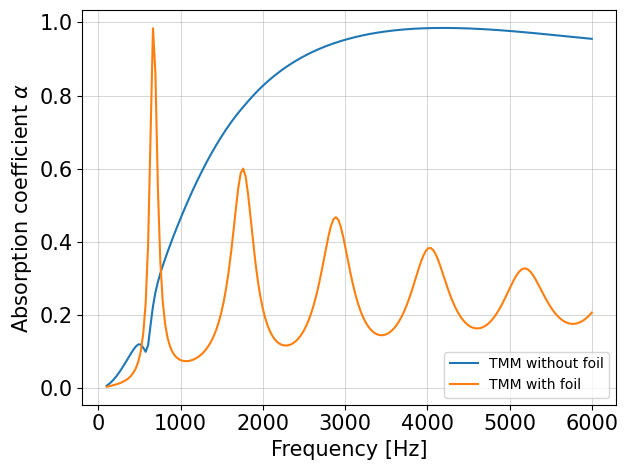

In [6]:
plt.plot(FreqList, alphaList[0], label = "TMM without foil")
plt.plot(FreqList, alphaList[1], label = "TMM with foil")

# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Absorption coefficient $\alpha$", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Absorption coefficient obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()


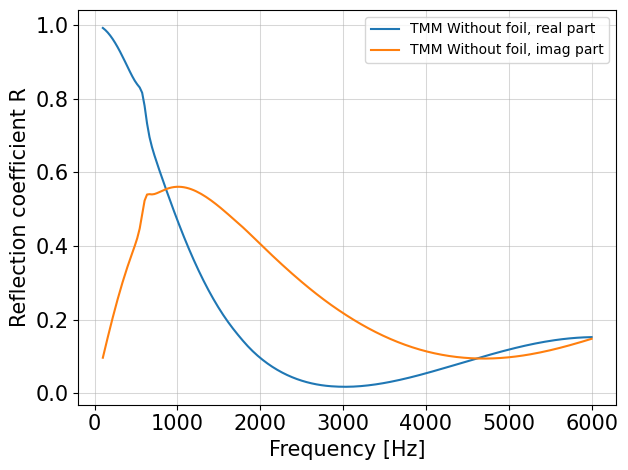

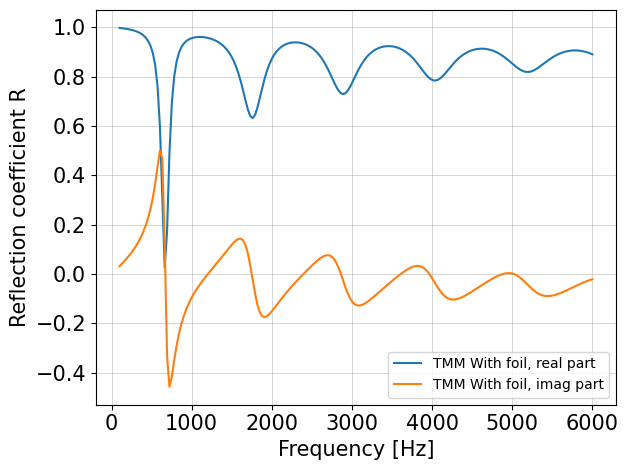

In [7]:
#### Without foil

plt.plot(FreqList, B1List[0].real, label = "TMM Without foil, real part")
plt.plot(FreqList, B1List[0].imag, label = "TMM Without foil, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Reflection coefficient R", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Reflection coefficient obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()

#### With foil

plt.plot(FreqList, B1List[1].real, label = "TMM With foil, real part")
plt.plot(FreqList, B1List[1].imag, label = "TMM With foil, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Reflection coefficient R", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Reflection coefficient obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()


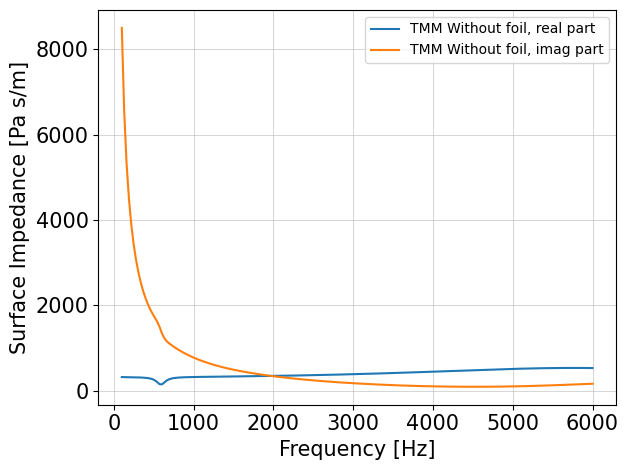

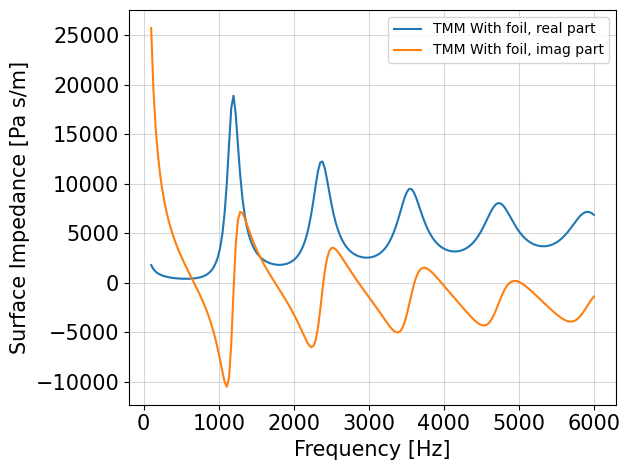

In [8]:
#### Without foil

plt.plot(FreqList, ZList[0].real, label = "TMM Without foil, real part")
plt.plot(FreqList, ZList[0].imag, label = "TMM Without foil, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel("Surface Impedance [Pa s/m]", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Surface impedance obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()

#### With foil

plt.plot(FreqList, ZList[1].real, label = "TMM With foil, real part")
plt.plot(FreqList, ZList[1].imag, label = "TMM With foil, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel("Surface Impedance [Pa s/m]", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Surface impedance obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()

## 7. Saving the data in a CSV

In [9]:
df = pd.DataFrame({
    'Frequency': FreqList, 
    'Absorption without foil': alphaList[0],
    'Absorption with foil': alphaList[1],
    'Reflection without foil': B1List[0], 
    'Reflection with foil': B1List[1],  
    'Surface impedance without foil': ZList[0],  
    'Surface impedance with foil': ZList[1]
})
#print(df.head)
df.to_csv('TMM Biot-JCAL.csv', index=False)